In [20]:
import gym
import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from matplotlib import pylab as plt

In [21]:
ENV_NAME = "Acrobot-v1"
SEED = 543
GAMMA = 0.99
RENDER = False
LOG_INTERVAL = 10

In [22]:
env = gym.make(ENV_NAME)
env.reset(seed=SEED)
_ = torch.manual_seed(SEED)

In [23]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 3)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

In [24]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [25]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

In [26]:
def finish_episode():
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy.rewards[::-1]:
        R = r + GAMMA * R
        returns.appendleft(R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [27]:
running_reward = 10
steps, running_rewards, ep_rewards = [], [], []
for i_episode in count(1):
    state, _ = env.reset()
    ep_reward = 0
    for t in range(1, 10000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _, _ = env.step(action)
        if RENDER:
            env.render()
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            break

    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    steps.append(i_episode)
    running_rewards.append(running_reward)
    ep_rewards.append(ep_reward)
    finish_episode()
    if i_episode % LOG_INTERVAL == 0:
        print(
            "Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}".format(
                i_episode, ep_reward, running_reward
            )
        )
    if running_reward > env.spec.reward_threshold:
        print(
            "Solved! Running reward is now {} and "
            "the last episode runs to {} time steps!".format(running_reward, t)
        )
        break

Episode 10	Last reward: -9999.00	Average reward: -4006.24
Episode 20	Last reward: -9999.00	Average reward: -6410.91
Episode 30	Last reward: -429.00	Average reward: -5145.32
Episode 40	Last reward: -215.00	Average reward: -3204.45
Episode 50	Last reward: -186.00	Average reward: -2004.89
Episode 60	Last reward: -155.00	Average reward: -1280.04
Episode 70	Last reward: -241.00	Average reward: -844.14
Episode 80	Last reward: -286.00	Average reward: -600.62
Episode 90	Last reward: -339.00	Average reward: -461.86
Episode 100	Last reward: -341.00	Average reward: -414.30
Episode 110	Last reward: -415.00	Average reward: -418.16
Episode 120	Last reward: -367.00	Average reward: -461.83
Episode 130	Last reward: -183.00	Average reward: -387.08
Episode 140	Last reward: -192.00	Average reward: -319.92
Episode 150	Last reward: -155.00	Average reward: -262.88
Episode 160	Last reward: -171.00	Average reward: -244.53
Episode 170	Last reward: -134.00	Average reward: -213.49
Episode 180	Last reward: -151.00

In [28]:
plt.rc("axes", titlesize=20, titleweight="bold")  # fontsize of the title
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=15)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=15)  # fontsize of the y tick labels
plt.rc("legend", fontsize=20)  # fontsize of the legend
plt.rc("figure", figsize=(12, 7))  # figure size

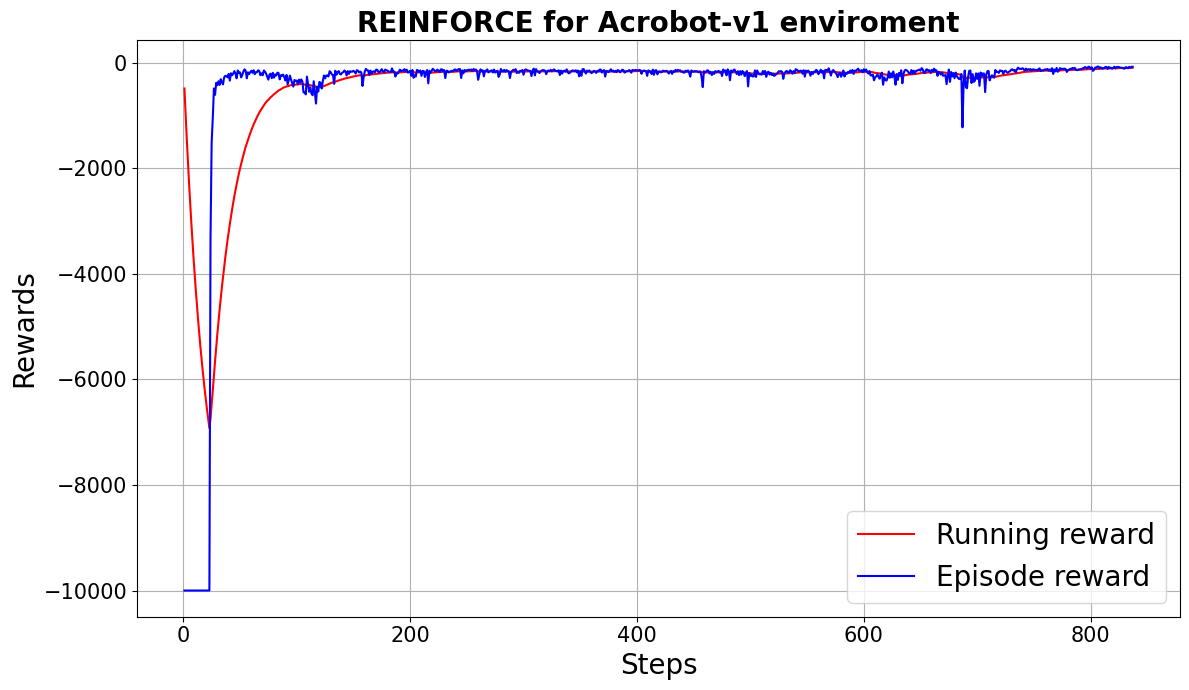

In [29]:
plt.plot(steps, running_rewards, label="Running reward", color="red")
plt.plot(steps, ep_rewards, label="Episode reward", color="blue")
plt.title(f"REINFORCE for {ENV_NAME} enviroment")
plt.xlabel("Steps")
plt.ylabel("Rewards")
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()